# 02 - Transform, Signals, Features, and Clustering

This notebook loads per-book embeddings, projects them with PCA, computes the Twist Signal, extracts story-level features, runs clustering, and optionally computes DTW distance-based similarity.

## Outputs
- `./data/processed/{book_id}/pca_d2.npy`
- `./data/processed/{book_id}/pca_d5.npy`
- `./data/processed/{book_id}/signals_k{K}.npz`
- `./data/processed/{book_id}/peaks_k{K}.json`
- `./outputs/features.csv`
- `./outputs/clusters_kmeans.csv`
- `./outputs/clusters_hier.csv`
- `./outputs/dtw_distance_k7.npy`
- `./outputs/pca/global_pca_fit.npz`
- `./outputs/pca/global_pca_fit_meta.json`
- `./outputs/pca/global_pca_variance_summary.csv`
- `./outputs/summary.md`


Note: this method was formerly referred to as "Option B" and is now documented as **Twist Signal**.


In [1]:
# Install required packages if missing
import importlib
import subprocess
import sys

REQUIRED_PACKAGES = [
    ("numpy", "numpy"),
    ("pandas", "pandas"),
    ("sklearn", "scikit-learn"),
    ("matplotlib", "matplotlib"),
]

for module_name, pip_name in REQUIRED_PACKAGES:
    try:
        importlib.import_module(module_name)
    except ImportError:
        print(f"Installing {pip_name} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pip_name])

# Try DTW package but allow fallback if unavailable.
try:
    importlib.import_module("dtaidistance")
    print("dtaidistance available.")
except ImportError:
    print("Attempting to install dtaidistance (optional) ...")
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "dtaidistance"])
    except Exception:
        print("dtaidistance installation failed; pure-Python DTW fallback will be used.")

print("Dependency check complete.")


Attempting to install dtaidistance (optional) ...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.6 MB/s  0:00:00 eta 0:00:01
Dependency check complete.


In [2]:
from pathlib import Path
import ast
import json
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

PROJECT_ROOT = Path(".").resolve()
DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed"
OUTPUTS_DIR = PROJECT_ROOT / "outputs"
METADATA_PATH = DATA_DIR / "metadata.csv"

OUTPUTS_DIR.mkdir(parents=True, exist_ok=True)

k_values = [7, 5, 11]
primary_k = 7
pca_dims = [2, 5]
top_K_peaks = 3
min_peak_separation = 3
n_clusters_default = 4
resample_len = 200
max_pca_fit_rows = 100_000

print(f"Processed dir: {PROCESSED_DIR}")
print(f"k values: {k_values}")


Processed dir: /Users/kongfha/Desktop/Time_Series_Mining/story-trajectory-analysis/data/processed
k values: [7, 5, 11]


In [3]:
metadata_df = None
book_embeddings = {}
book_artifact_dirs = {}

if METADATA_PATH.exists():
    metadata_df = pd.read_csv(METADATA_PATH)
    if "id" not in metadata_df.columns and "pg_id" in metadata_df.columns:
        metadata_df["id"] = metadata_df["pg_id"]

    if "raw_filename" not in metadata_df.columns:
        metadata_df["raw_filename"] = ""
    if "processed_dir" not in metadata_df.columns:
        metadata_df["processed_dir"] = ""

    for col in ["genre_secondary", "short_tags", "citations"]:
        if col in metadata_df.columns:
            def _parse_listlike(v):
                if not isinstance(v, str) or not v.strip().startswith("["):
                    return v
                try:
                    parsed = json.loads(v)
                except Exception:
                    try:
                        parsed = ast.literal_eval(v)
                    except Exception:
                        return v
                if isinstance(parsed, list):
                    return ", ".join(str(x) for x in parsed)
                return v
            metadata_df[col] = metadata_df[col].apply(_parse_listlike)

    for row in metadata_df.sort_values("id").to_dict(orient="records"):
        book_id = str(int(row["id"]))
        processed_dir = str(row.get("processed_dir", "") or "").strip()
        if not processed_dir:
            raw_filename = str(row.get("raw_filename", "") or "").strip()
            processed_dir = Path(raw_filename).stem if raw_filename else book_id

        candidates = [PROCESSED_DIR / processed_dir, PROCESSED_DIR / book_id]
        chosen_dir = None
        for d in candidates:
            emb_path = d / "embeddings.npy"
            idx_path = d / "index.json"
            if emb_path.exists() and idx_path.exists():
                chosen_dir = d
                break

        if chosen_dir is None:
            continue

        emb = np.load(chosen_dir / "embeddings.npy")
        if emb.ndim != 2 or emb.shape[0] < 2:
            continue

        book_embeddings[book_id] = emb.astype(np.float32, copy=False)
        book_artifact_dirs[book_id] = chosen_dir

else:
    # Fallback mode if metadata is absent
    book_dirs = sorted([p for p in PROCESSED_DIR.iterdir() if p.is_dir()])
    for d in book_dirs:
        emb_path = d / "embeddings.npy"
        idx_path = d / "index.json"
        if not emb_path.exists() or not idx_path.exists():
            continue

        idx = json.loads(idx_path.read_text(encoding="utf-8"))
        book_id = str(idx.get("book_id", d.name))
        emb = np.load(emb_path)
        if emb.ndim != 2 or emb.shape[0] < 2:
            continue

        book_embeddings[book_id] = emb.astype(np.float32, copy=False)
        book_artifact_dirs[book_id] = d

if not book_embeddings:
    raise RuntimeError("No embeddings found under data/processed/* for the current metadata list")

print(f"Books with embeddings: {len(book_embeddings)}")
print("Sample IDs:", list(book_embeddings.keys())[:8])
if metadata_df is not None:
    print(f"Metadata rows available: {len(metadata_df)}")


Books with embeddings: 20
Sample IDs: ['11', '16', '35', '36', '43', '55', '84', '103']
Metadata rows available: 20


In [4]:
def compute_novelty_signal(emb: np.ndarray, k: int, eps: float = 1e-8):
    T, D = emb.shape
    s = np.zeros(T, dtype=np.float32)

    csum = np.cumsum(emb, axis=0, dtype=np.float64)

    for t in range(T):
        if t == 0:
            context = emb[0]
        else:
            start = max(0, t - k)
            count = t - start
            context_sum = csum[t - 1].copy()
            if start > 0:
                context_sum -= csum[start - 1]
            context = context_sum / max(count, 1)

        dot_val = float(np.dot(emb[t], context))
        denom = float(np.linalg.norm(emb[t]) * np.linalg.norm(context) + eps)
        cos_sim = dot_val / denom if denom > 0 else 0.0
        s[t] = np.float32(1.0 - cos_sim)

    a = np.zeros(T, dtype=np.float32)
    if T > 1:
        a[1:] = np.abs(np.diff(s)).astype(np.float32)

    return s, a


def pick_top_peaks(signal: np.ndarray, top_k: int = 3, min_separation: int = 3):
    if signal.size == 0:
        return []

    ranked = np.argsort(signal)[::-1]
    selected = []

    for idx in ranked:
        idx = int(idx)
        if any(abs(idx - s) < min_separation for s in selected):
            continue
        selected.append(idx)
        if len(selected) >= top_k:
            break

    selected.sort()
    return selected


def peak_positions_normalized(peak_indices, T: int):
    if T <= 1:
        return [0.0 for _ in peak_indices]
    return [float(idx / (T - 1)) for idx in peak_indices]


def build_feature_row(book_id: str, k: int, s: np.ndarray, a: np.ndarray, peak_indices):
    T = len(s)
    peak_pos = peak_positions_normalized(peak_indices, T)

    while len(peak_pos) < 3:
        peak_pos.append(-1.0)

    return {
        "book_id": int(book_id),
        "k": int(k),
        "T": int(T),
        "mean_s": float(np.mean(s)),
        "std_s": float(np.std(s)),
        "max_s": float(np.max(s)),
        "mean_a": float(np.mean(a)),
        "std_a": float(np.std(a)),
        "max_a": float(np.max(a)),
        "num_peaks": int(len(peak_indices)),
        "peak_pos_1": float(peak_pos[0]),
        "peak_pos_2": float(peak_pos[1]),
        "peak_pos_3": float(peak_pos[2]),
        "auc_proxy_mean_s": float(np.mean(s)),
    }


def resample_signal(signal: np.ndarray, target_len: int = 200):
    if signal.size == 0:
        return np.zeros(target_len, dtype=np.float32)
    if signal.size == 1:
        return np.full(target_len, float(signal[0]), dtype=np.float32)

    old_x = np.linspace(0.0, 1.0, num=signal.size)
    new_x = np.linspace(0.0, 1.0, num=target_len)
    return np.interp(new_x, old_x, signal).astype(np.float32)


def dtw_distance_py(x: np.ndarray, y: np.ndarray):
    n = len(x)
    m = len(y)
    prev = np.full(m + 1, np.inf, dtype=np.float64)
    prev[0] = 0.0

    for i in range(1, n + 1):
        curr = np.full(m + 1, np.inf, dtype=np.float64)
        xi = x[i - 1]
        for j in range(1, m + 1):
            cost = abs(float(xi) - float(y[j - 1]))
            curr[j] = cost + min(curr[j - 1], prev[j], prev[j - 1])
        prev = curr

    return float(prev[m])


def compute_dtw_distance_matrix(series_by_book: dict):
    book_ids = sorted(series_by_book.keys(), key=lambda x: int(x))
    n = len(book_ids)
    dist = np.zeros((n, n), dtype=np.float32)

    dtw_backend = "python"
    dtw_lib = None
    try:
        from dtaidistance import dtw as dtw_lib
        dtw_backend = "dtaidistance"
    except Exception:
        dtw_backend = "python"

    for i in range(n):
        xi = series_by_book[book_ids[i]]
        for j in range(i + 1, n):
            xj = series_by_book[book_ids[j]]
            if dtw_backend == "dtaidistance":
                try:
                    d = float(dtw_lib.distance_fast(xi.astype(np.double), xj.astype(np.double), use_pruning=True))
                except Exception:
                    try:
                        d = float(dtw_lib.distance(xi.astype(np.double), xj.astype(np.double)))
                    except Exception:
                        d = dtw_distance_py(xi, xj)
            else:
                d = dtw_distance_py(xi, xj)

            dist[i, j] = dist[j, i] = np.float32(d)

    return book_ids, dist, dtw_backend


def agglomerative_precomputed(dist_matrix: np.ndarray, n_clusters: int):
    try:
        model = AgglomerativeClustering(
            n_clusters=n_clusters,
            metric="precomputed",
            linkage="average",
        )
    except TypeError:
        model = AgglomerativeClustering(
            n_clusters=n_clusters,
            affinity="precomputed",
            linkage="average",
        )
    return model.fit_predict(dist_matrix)


In [5]:
# Fit PCA on pooled embeddings (or sample if large), then save per-book PCA projections
all_book_ids = sorted(book_embeddings.keys(), key=lambda x: int(x))
all_emb_list = [book_embeddings[b] for b in all_book_ids]
all_emb = np.vstack(all_emb_list)

print(f"Total embedding rows across all books: {all_emb.shape[0]}")

fit_matrix = all_emb
if all_emb.shape[0] > max_pca_fit_rows:
    rng = np.random.default_rng(SEED)
    sample_idx = rng.choice(all_emb.shape[0], size=max_pca_fit_rows, replace=False)
    fit_matrix = all_emb[sample_idx]
    print(f"Using sampled rows for PCA fit: {fit_matrix.shape[0]}")

pca = PCA(n_components=5, svd_solver="randomized", random_state=SEED)
pca.fit(fit_matrix)

# Persist global PCA model artifacts for reproducible downstream analysis.
pca_outputs_dir = OUTPUTS_DIR / "pca"
pca_outputs_dir.mkdir(parents=True, exist_ok=True)

global_pca_path = pca_outputs_dir / "global_pca_fit.npz"
np.savez(
    global_pca_path,
    components=pca.components_.astype(np.float32),
    explained_variance=pca.explained_variance_.astype(np.float32),
    explained_variance_ratio=pca.explained_variance_ratio_.astype(np.float32),
    singular_values=pca.singular_values_.astype(np.float32),
    mean=pca.mean_.astype(np.float32),
)

global_pca_meta_path = pca_outputs_dir / "global_pca_fit_meta.json"
model_name = None
for book_id in all_book_ids:
    index_path = book_artifact_dirs[book_id] / "index.json"
    if not index_path.exists():
        continue
    try:
        idx = json.loads(index_path.read_text(encoding="utf-8"))
        model_name = idx.get("model_name")
    except Exception:
        model_name = None
    if model_name:
        break

global_pca_meta = {
    "seed": int(SEED),
    "n_components": int(pca.n_components),
    "svd_solver": str(pca.svd_solver),
    "fit_rows_used": int(fit_matrix.shape[0]),
    "fit_rows_total": int(all_emb.shape[0]),
    "embedding_dim": int(all_emb.shape[1]),
    "model_name": model_name,
    "created_at": pd.Timestamp.utcnow().isoformat(),
}
global_pca_meta_path.write_text(json.dumps(global_pca_meta, indent=2), encoding="utf-8")

variance_path = pca_outputs_dir / "global_pca_variance_summary.csv"
variance_df = pd.DataFrame(
    {
        "pc": [f"PC{i}" for i in range(1, len(pca.explained_variance_ratio_) + 1)],
        "explained_variance_ratio": pca.explained_variance_ratio_.astype(np.float64),
        "cumulative_explained_variance_ratio": np.cumsum(pca.explained_variance_ratio_.astype(np.float64)),
    }
)
variance_df.to_csv(variance_path, index=False)

for book_id in all_book_ids:
    emb = book_embeddings[book_id]
    z5 = pca.transform(emb).astype(np.float32)
    z2 = z5[:, :2].astype(np.float32)

    book_dir = book_artifact_dirs[book_id]
    np.save(book_dir / "pca_d5.npy", z5)
    np.save(book_dir / "pca_d2.npy", z2)

print("Saved PCA projections per book (d=2 and d=5).")
print(f"Saved global PCA fit artifact: {global_pca_path}")
print(f"Saved global PCA metadata: {global_pca_meta_path}")
print(f"Saved global PCA variance summary: {variance_path}")



Total embedding rows across all books: 21337
Saved PCA projections per book (d=2 and d=5).


In [6]:
# Compute novelty/twist signals, peaks, and story-level features
feature_rows = []
signal_store = {k: {} for k in k_values}

for book_id in all_book_ids:
    emb = book_embeddings[book_id]
    T = emb.shape[0]
    book_dir = book_artifact_dirs[book_id]

    for k in k_values:
        s, a = compute_novelty_signal(emb, k=k)

        if not np.isfinite(s).all() or not np.isfinite(a).all():
            raise RuntimeError(f"Non-finite values in signal for book {book_id}, k={k}")
        if len(s) != T or len(a) != T:
            raise RuntimeError(f"Signal length mismatch for book {book_id}, k={k}")

        np.savez(book_dir / f"signals_k{k}.npz", s=s.astype(np.float32), a=a.astype(np.float32))

        peaks = pick_top_peaks(a, top_k=top_K_peaks, min_separation=min_peak_separation)
        peak_pos = peak_positions_normalized(peaks, T)

        peaks_payload = {
            "book_id": int(book_id),
            "k": int(k),
            "top_K": int(top_K_peaks),
            "separation": int(min_peak_separation),
            "peak_indices": [int(x) for x in peaks],
            "peak_positions_norm": [float(x) for x in peak_pos],
            "signal": "a_t",
        }
        (book_dir / f"peaks_k{k}.json").write_text(json.dumps(peaks_payload, indent=2), encoding="utf-8")

        feature_rows.append(build_feature_row(book_id=book_id, k=k, s=s, a=a, peak_indices=peaks))
        signal_store[k][book_id] = s.astype(np.float32)

features_df = pd.DataFrame(feature_rows)
if features_df.empty:
    raise RuntimeError("No feature rows generated.")

features_df = features_df.sort_values(["k", "book_id"]).reset_index(drop=True)

if metadata_df is not None and "id" in metadata_df.columns:
    merge_cols = [
        "id", "title", "author", "first_publication_year", "origin_country", "original_language",
        "format", "genre_primary", "genre_secondary", "short_tags", "recognizability_rank",
        "genre_clarity_rank", "twist_peak_rank", "twist_peak_reason", "notes", "ebook_page_url",
        "plain_text_utf8_url", "raw_filename", "processed_dir", "length", "status", "citations",
    ]
    meta_subset = metadata_df[[c for c in merge_cols if c in metadata_df.columns]].copy()
    meta_subset = meta_subset.rename(columns={"id": "book_id"})
    features_df = features_df.merge(meta_subset, on="book_id", how="left")

features_path = OUTPUTS_DIR / "features.csv"
features_df.to_csv(features_path, index=False)
print(f"Saved features: {features_path}")
display(features_df.head(10))


Saved features: /Users/kongfha/Desktop/Time_Series_Mining/story-trajectory-analysis/outputs/features.csv


,book_id,k,T,mean_s,std_s,max_s,mean_a,std_a,max_a,num_peaks,...,twist_peak_rank,twist_peak_reason,notes,ebook_page_url,plain_text_utf8_url,raw_filename,processed_dir,length,status,citations
0,11,5,264,0.193677,0.054509,0.479806,0.042886,0.039751,0.336253,3,...,19,Picaresque and episodic structure; the 'it was...,Lewis Carroll is the pen name of Charles Lutwi...,https://www.gutenberg.org/ebooks/11,https://www.gutenberg.org/ebooks/11.txt.utf-8,alice_s_adventures_wonderland.txt,alice_s_adventures_wonderland,26525,downloaded_marker,https://en.wikipedia.org/wiki/Alice%27s_Advent...
1,16,5,471,0.193338,0.059335,0.440018,0.048597,0.041305,0.246600,3,...,17,Contains an action-packed final clash with Cap...,Play first performed in 1904; novelized as 'Pe...,https://www.gutenberg.org/ebooks/16,https://www.gutenberg.org/ebooks/16.txt.utf-8,peter_pan.txt,peter_pan,47268,downloaded_marker,"https://en.wikipedia.org/wiki/Peter_and_Wendy,..."
2,35,5,323,0.209637,0.071191,0.579908,0.053236,0.050402,0.414458,3,...,13,The revelation of the predatory Morlocks feedi...,Serialized early 1895; book published later th...,https://www.gutenberg.org/ebooks/35,https://www.gutenberg.org/ebooks/35.txt.utf-8,time_machine.txt,time_machine,32453,downloaded_marker,https://en.wikipedia.org/wiki/The_Time_Machine...
3,36,5,599,0.193025,0.065509,0.518367,0.052485,0.045671,0.255779,3,...,14,The sudden defeat of the seemingly invincible ...,"Serialized in 1897, published as a book in 1898.",https://www.gutenberg.org/ebooks/36,https://www.gutenberg.org/ebooks/36.txt.utf-8,war_worlds.txt,war_worlds,60076,downloaded_marker,https://en.wikipedia.org/wiki/The_War_of_the_W...
4,43,5,255,0.171060,0.070378,0.479637,0.052429,0.051354,0.434336,3,...,1,Contains one of the most famous plot twists in...,Stevenson was Scottish; published in the UK.,https://www.gutenberg.org/ebooks/43,https://www.gutenberg.org/ebooks/43.txt.utf-8,strange_case_dr_jekyll.txt,strange_case_dr_jekyll,25629,downloaded_marker,https://en.wikipedia.org/wiki/Strange_Case_of_...
5,55,5,395,0.165078,0.061020,0.455548,0.044351,0.039539,0.296198,3,...,16,Features a solid late-narrative twist that the...,First published in Chicago.,https://www.gutenberg.org/ebooks/55,https://www.gutenberg.org/ebooks/55.txt.utf-8,wonderful_wizard_oz.txt,wonderful_wizard_oz,39649,downloaded_marker,https://en.wikipedia.org/wiki/The_Wonderful_Wi...
6,84,5,749,0.192789,0.068918,0.491165,0.050650,0.044555,0.491165,3,...,11,Escalates with shocking murders of Victor's lo...,First published anonymously in 1818. Revised 1...,https://www.gutenberg.org/ebooks/84,https://www.gutenberg.org/ebooks/84.txt.utf-8,frankenstein_modern_prometheus.txt,frankenstein_modern_prometheus,75042,downloaded_marker,"https://en.wikipedia.org/wiki/Frankenstein, ht..."
7,103,5,632,0.179996,0.070737,0.493254,0.050169,0.043161,0.295461,3,...,10,"Culminates in a legendary, unexpected twist en...",First published in French in 1872.,https://www.gutenberg.org/ebooks/103,https://www.gutenberg.org/ebooks/103.txt.utf-8,around_world_eighty_days.txt,around_world_eighty_days,63334,downloaded_marker,https://en.wikipedia.org/wiki/Around_the_World...
8,113,5,805,0.186660,0.057619,0.467386,0.046939,0.039839,0.467386,3,...,18,"A steady, emotional slice-of-life healing narr...","Serialized starting in 1910, published as a bo...",https://www.gutenberg.org/ebooks/113,https://www.gutenberg.org/ebooks/113.txt.utf-8,secret_garden.txt,secret_garden,80632,downloaded_marker,https://en.wikipedia.org/wiki/The_Secret_Garde...
9,120,5,685,0.182644,0.053898,0.385123,0.044692,0.038212,0.326816,3,...,9,Driven by Long John Silver's shocking mutiny a...,Serialized 1881-1882 before book publication.,https://www.gutenberg.org/ebooks/120,https://www.gutenberg.org/ebooks/120.txt.utf-8,treasure_island.txt,treasure_island,68637,downloaded_marker,"https://en.wikipedia.org/wiki/Treasure_Island,..."


In [7]:
# Feature-based clustering + DTW-based clustering (k=7)
feature_cols = [
    "mean_s", "std_s", "max_s",
    "mean_a", "std_a", "max_a",
    "num_peaks", "peak_pos_1", "peak_pos_2", "peak_pos_3",
    "auc_proxy_mean_s", "T",
]

kmeans_rows = []
hier_rows = []

for k in sorted(features_df["k"].unique()):
    subset = features_df[features_df["k"] == k].sort_values("book_id").reset_index(drop=True)
    X = subset[feature_cols].values

    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)

    km = KMeans(n_clusters=n_clusters_default, random_state=SEED, n_init=20)
    km_labels = km.fit_predict(Xs)

    ward = AgglomerativeClustering(n_clusters=n_clusters_default, linkage="ward")
    ward_labels = ward.fit_predict(Xs)

    for i, book_id in enumerate(subset["book_id"].tolist()):
        kmeans_rows.append({
            "book_id": int(book_id),
            "k": int(k),
            "n_clusters": int(n_clusters_default),
            "cluster": int(km_labels[i]),
        })
        hier_rows.append({
            "book_id": int(book_id),
            "k": int(k),
            "mode": "feature_ward",
            "n_clusters": int(n_clusters_default),
            "cluster": int(ward_labels[i]),
        })

# DTW matrix and clustering for primary k
if primary_k not in signal_store or not signal_store[primary_k]:
    raise RuntimeError(f"No signals found for primary_k={primary_k}")

resampled = {
    book_id: resample_signal(sig, target_len=resample_len)
    for book_id, sig in signal_store[primary_k].items()
}

book_ids_dtw, dtw_matrix, dtw_backend = compute_dtw_distance_matrix(resampled)
if dtw_matrix.shape[0] != dtw_matrix.shape[1]:
    raise RuntimeError("DTW distance matrix must be square")
if not np.allclose(dtw_matrix, dtw_matrix.T, atol=1e-6):
    raise RuntimeError("DTW distance matrix must be symmetric")
if not np.allclose(np.diag(dtw_matrix), 0.0, atol=1e-6):
    raise RuntimeError("DTW distance matrix must have zero diagonal")

np.save(OUTPUTS_DIR / "dtw_distance_k7.npy", dtw_matrix)

dtw_labels = agglomerative_precomputed(dtw_matrix, n_clusters=n_clusters_default)
for i, book_id in enumerate(book_ids_dtw):
    hier_rows.append({
        "book_id": int(book_id),
        "k": int(primary_k),
        "mode": "dtw_average",
        "n_clusters": int(n_clusters_default),
        "cluster": int(dtw_labels[i]),
    })

clusters_kmeans_df = pd.DataFrame(kmeans_rows).sort_values(["k", "book_id"]).reset_index(drop=True)
clusters_hier_df = pd.DataFrame(hier_rows).sort_values(["mode", "k", "book_id"]).reset_index(drop=True)

if metadata_df is not None and "id" in metadata_df.columns:
    meta_cols = ["id", "title", "author", "genre_primary", "format", "processed_dir", "first_publication_year", "recognizability_rank", "twist_peak_rank"]
    meta_subset = metadata_df[[c for c in meta_cols if c in metadata_df.columns]].copy().rename(columns={"id": "book_id"})
    clusters_kmeans_df = clusters_kmeans_df.merge(meta_subset, on="book_id", how="left")
    clusters_hier_df = clusters_hier_df.merge(meta_subset, on="book_id", how="left")

clusters_kmeans_df.to_csv(OUTPUTS_DIR / "clusters_kmeans.csv", index=False)
clusters_hier_df.to_csv(OUTPUTS_DIR / "clusters_hier.csv", index=False)

print(f"DTW backend used: {dtw_backend}")
print(f"Saved KMeans clusters: {OUTPUTS_DIR / 'clusters_kmeans.csv'}")
print(f"Saved hierarchical clusters: {OUTPUTS_DIR / 'clusters_hier.csv'}")


The compiled dtaidistance C library is not available.
See the documentation for alternative installation options.
The compiled dtaidistance C library is not available.
See the documentation for alternative installation options.
The compiled dtaidistance C library is not available.
See the documentation for alternative installation options.
The compiled dtaidistance C library is not available.
See the documentation for alternative installation options.
The compiled dtaidistance C library is not available.
See the documentation for alternative installation options.
The compiled dtaidistance C library is not available.
See the documentation for alternative installation options.
The compiled dtaidistance C library is not available.
See the documentation for alternative installation options.
The compiled dtaidistance C library is not available.
See the documentation for alternative installation options.
The compiled dtaidistance C library is not available.
See the documentation for alternat

DTW backend used: dtaidistance
Saved KMeans clusters: /Users/kongfha/Desktop/Time_Series_Mining/story-trajectory-analysis/outputs/clusters_kmeans.csv
Saved hierarchical clusters: /Users/kongfha/Desktop/Time_Series_Mining/story-trajectory-analysis/outputs/clusters_hier.csv


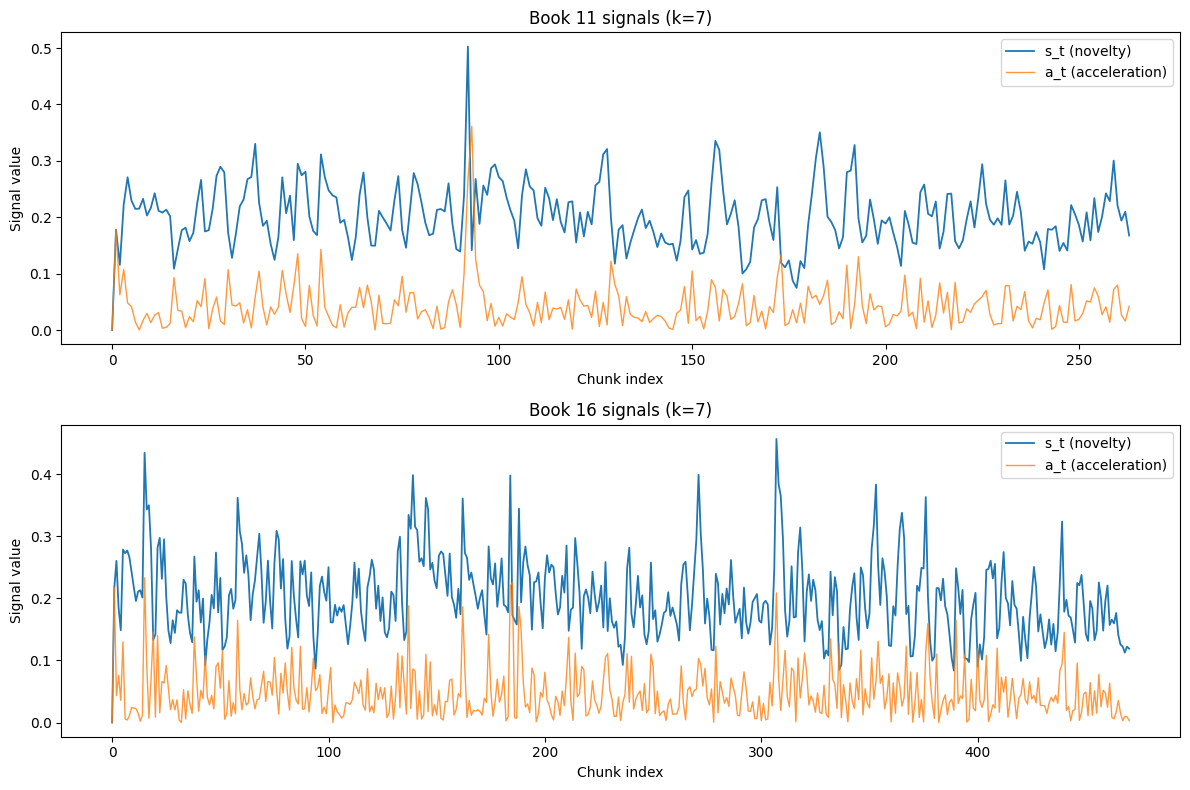

Saved summary: /Users/kongfha/Desktop/Time_Series_Mining/story-trajectory-analysis/outputs/summary.md
# Story Trajectory Pipeline Summary

## Created artifacts
- Books processed: 20
- Feature rows: 60
- k values: [7, 5, 11]
- PCA dimensions saved per book: [2, 5]
- KMeans clusters file: /Users/kongfha/Desktop/Time_Series_Mining/story-trajectory-analysis/outputs/clusters_kmeans.csv
- Hierarchical clusters file: /Users/kongfha/Desktop/Time_Series_Mining/story-trajectory-analysis/outputs/clusters_hier.csv
- DTW distance matrix: /Users/kongfha/Desktop/Time_Series_Mining/story-trajectory-analysis/outputs/dtw_distance_k7.npy
- DTW resample length: 200
- Metadata file: /Users/kongfha/Desktop/Time_Series_Mining/story-trajectory-analysis/data/metadata.csv (exists=True)
- Sanity plot: /Users/kongfha/Desktop/Time_Series_Mining/story-trajectory-analysis/outputs/sanity_signal_examples.png



In [8]:
# Minimal sanity plots and summary report
example_ids = sorted(signal_store[primary_k].keys(), key=lambda x: int(x))[:2]

if example_ids:
    fig, axes = plt.subplots(len(example_ids), 1, figsize=(12, 4 * len(example_ids)), sharex=False)
    if len(example_ids) == 1:
        axes = [axes]

    for ax, book_id in zip(axes, example_ids):
        s = signal_store[primary_k][book_id]
        emb = book_embeddings[book_id]
        _, a = compute_novelty_signal(emb, k=primary_k)

        ax.plot(s, label="s_t (novelty)", linewidth=1.3)
        ax.plot(a, label="a_t (acceleration)", linewidth=1.0, alpha=0.8)
        ax.set_title(f"Book {book_id} signals (k={primary_k})")
        ax.set_xlabel("Chunk index")
        ax.set_ylabel("Signal value")
        ax.legend(loc="upper right")

    fig.tight_layout()
    sanity_plot_path = OUTPUTS_DIR / "sanity_signal_examples.png"
    fig.savefig(sanity_plot_path, dpi=140)
    plt.show()
else:
    sanity_plot_path = None

summary_lines = [
    "# Story Trajectory Pipeline Summary",
    "",
    "## Created artifacts",
    f"- Books processed: {len(all_book_ids)}",
    f"- Feature rows: {len(features_df)}",
    f"- k values: {k_values}",
    f"- PCA dimensions saved per book: {pca_dims}",
    f"- Global PCA fit artifact: {global_pca_path}",
    f"- Global PCA metadata: {global_pca_meta_path}",
    f"- Global PCA variance summary: {variance_path}",
    f"- KMeans clusters file: {OUTPUTS_DIR / 'clusters_kmeans.csv'}",
    f"- Hierarchical clusters file: {OUTPUTS_DIR / 'clusters_hier.csv'}",
    f"- DTW distance matrix: {OUTPUTS_DIR / 'dtw_distance_k7.npy'}",
    f"- DTW resample length: {resample_len}",
    f"- Metadata file: {METADATA_PATH} (exists={METADATA_PATH.exists()})",
]

if sanity_plot_path is not None:
    summary_lines.append(f"- Sanity plot: {sanity_plot_path}")

summary_text = "\n".join(summary_lines) + "\n"
summary_path = OUTPUTS_DIR / "summary.md"
summary_path.write_text(summary_text, encoding="utf-8")

print(f"Saved summary: {summary_path}")
print(summary_text)
